<a href="https://colab.research.google.com/github/IBNH/Deep-CV/blob/main/Deep%20CV%20Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Resnet

Credit: Sohom Paul, Saathvik Selvan, Aryan Jain

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [ ]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

Recall that `torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

In [ ]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_size = 40_000
val_size = 10_000

In [ ]:
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

100%|██████████| 170498071/170498071 [00:04<00:00, 36799128.60it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

showing training images


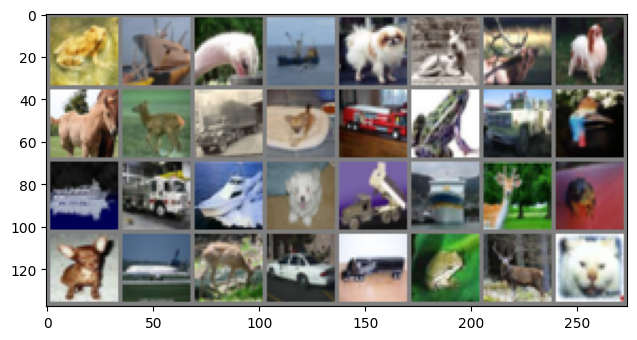

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. Let's try implementing one.

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future ues
        layer_dims: list of integers, representing the width
            of each of the layers of our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        '''

        super().__init__()
        self.linear1 = nn.Linear(layer_dims[0], layer_dims[1])
        self.linear2 = nn.Linear(layer_dims[1], layer_dims[2])
        self.act_hidden = nn.ReLU()
        self.flatten = nn.Flatten()
        self.act_final = nn.Softmax()


    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''

        out = self.flatten(x)
        out = self.linear1(out)
        out = self.act_hidden(out)
        out = self.linear2(out)
        out = self.act_final(out)
        return out



... and their corresponding labels
frog     ship     bird     ship     dog      deer     deer     dog     
horse    deer     truck    dog      truck    frog     truck    bird    
ship     truck    ship     dog      truck    ship     deer     frog    
dog      plane    deer     car      truck    frog     deer     cat     


Here you will get a chance to implement parts of our training and validation loops. If you find yourself struggling, take a look at the training loop from the first homework -- these loops are usually pretty standard and have many similarities regardless of the model.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0

    model = model.to(device)
    model.eval()


    for inputs, labels in tqdm(loader, leave=False):

        y_simplex = torch.zeros((labels.shape[0], 10)).to(device)
        for i in range(labels.shape[0]):
              y_simplex[i, labels[i]] = 1
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        pred = model(inputs)
        loss = criterion(pred, y_simplex)
        total_correct += torch.sum(torch.argmax(pred, dim=1) == labels).item()

    return total_correct / len(loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path = None, scheduler = None):
    print('beginning to train model')
    if path and not os.path.exists(path):
      os.makedirs(path)

    model = model.to(device)


    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):

            y_simplex = torch.zeros((batch_size, 10)).to(device)
            for i in range(batch_size):
              y_simplex[i, labels[i]] = 1
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            torch.autograd.set_detect_anomaly(True)
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, y_simplex)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        if path:
          torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')
        end_time = time.perf_counter()
        duration = end_time - start_time

        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)


        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2812.146	time: 23.573	train acc: 0.2544	val acc: 0.2509


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2727.890	time: 20.101	train acc: 0.3158	val acc: 0.3044


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 2675.311	time: 20.659	train acc: 0.3462	val acc: 0.3358


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 2644.280	time: 18.929	train acc: 0.3638	val acc: 0.3453


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 2626.114	time: 19.990	train acc: 0.3747	val acc: 0.3566


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 2612.272	time: 20.451	train acc: 0.3841	val acc: 0.3639


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 2601.935	time: 19.539	train acc: 0.3908	val acc: 0.3706


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 2592.700	time: 20.342	train acc: 0.3984	val acc: 0.3788


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 2583.372	time: 20.691	train acc: 0.4071	val acc: 0.3853


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 2574.063	time: 19.370	train acc: 0.4173	val acc: 0.3924


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 2565.579	time: 20.378	train acc: 0.4217	val acc: 0.3964


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 2557.977	time: 21.492	train acc: 0.4278	val acc: 0.3995


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 2551.279	time: 20.277	train acc: 0.4344	val acc: 0.4043


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 2545.223	time: 20.523	train acc: 0.4377	val acc: 0.4077


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 2539.435	time: 19.642	train acc: 0.4423	val acc: 0.4103


As a final observation, let's print the number of parameters that this network learned.

In [ ]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and the lecture slides posted on the course website!

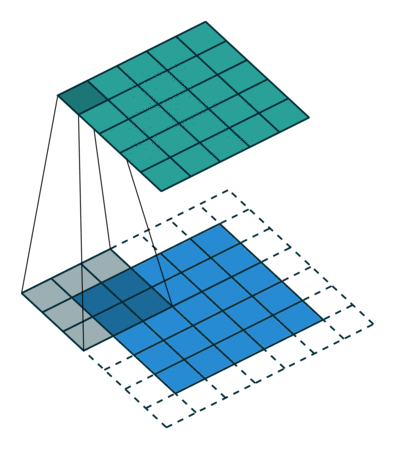

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future ues.

        Please use the following network structure:
        - conv layer with 5 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - conv layer with 16 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - linear (fully-connected) layer with 120 output dims
        - linear (fully-connected) layer with 84 output dims
        - linear (fully-connected) layer with 10 output dims

        After any convolutional or linear layer EXCEPT for the final output,
        we will use a relu activation.
        '''

        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.conv2 = nn.Conv2d(5, 16, 5)
        self.pool1 = nn.MaxPool2d((2,2), 2)
        self.pool2 = nn.MaxPool2d((2, 2), 2)
        self.linear1 = nn.Linear(400, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()
        self.act_hidden = nn.ReLU()
        self.act_final = nn.Softmax()


    def forward(self, x):
        '''
        Compute a forward pass of your batch of images. Refer to the docstring
        for the init method for the order in which to call

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''

        out = self.conv1(x)
        out = self.act_hidden(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.act_hidden(out)
        out = self.pool2(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act_hidden(out)
        out = self.linear2(out)
        out = self.act_hidden(out)
        out = self.linear3(out)
        out = self.act_final(out)
        return out


In [ ]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2878.276	time: 33.095	train acc: 0.1119	val acc: 0.1100


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2878.227	time: 27.296	train acc: 0.1219	val acc: 0.1211


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 2878.168	time: 30.103	train acc: 0.1313	val acc: 0.1316


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 2878.094	time: 29.245	train acc: 0.1302	val acc: 0.1295


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 2877.996	time: 29.964	train acc: 0.1208	val acc: 0.1185


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 2877.854	time: 30.066	train acc: 0.1124	val acc: 0.1074


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 2877.618	time: 29.430	train acc: 0.1061	val acc: 0.1014


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 2877.164	time: 30.762	train acc: 0.1020	val acc: 0.0993


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 2876.193	time: 30.723	train acc: 0.1205	val acc: 0.1187


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 2873.440	time: 29.142	train acc: 0.1250	val acc: 0.1258


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 2858.752	time: 29.288	train acc: 0.1705	val acc: 0.1681


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 2799.921	time: 29.671	train acc: 0.2515	val acc: 0.2546


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 2736.444	time: 29.793	train acc: 0.2787	val acc: 0.2725


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 2703.064	time: 29.595	train acc: 0.3008	val acc: 0.2939


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 2682.970	time: 29.232	train acc: 0.3177	val acc: 0.3110


In [ ]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: Using ResNet for Classification

The network that we're implementing here is here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead and skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model.

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 3x3 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be an no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        super().__init__()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
          self.shortcut = nn.Sequential(
              self.conv(in_channels, out_channels, (3,3), stride),
              nn.BatchNorm2d(out_channels)
          )
        self.conv1 = self.conv(in_channels, out_channels, (3,3), stride)
        self.conv2 = self.conv(out_channels, out_channels, (3,3), 1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.flatten = nn.Flatten()
        self.act_hidden = nn.ReLU()
        self.act_hidden2 = nn.ReLU()


    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data on this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.act_hidden(out)
        out = self.conv2(out)
        out = self.batch2(out)
        shortcut = self.shortcut(x)
        return self.act_hidden2(out + shortcut)


class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [ ]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

Now that we have defined our model, feel free to use this `torchsummary` package function to visualize how an image is passed through the network and how the layers change the shape of the image. The final convolution layer should output a tensor of size `(32, 512, 4, 4)`, which is averaged, flattened, and passed through a fully connected layer to end up with a `(32, 10)` tensor of classification scores. To evaluate predictions, we simply take the `argmax` of our output.



In [ ]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
              ReLU-5           [32, 64, 32, 32]               0
            Conv2d-6           [32, 64, 32, 32]          36,864
       BatchNorm2d-7           [32, 64, 32, 32]             128
              ReLU-8           [32, 64, 32, 32]               0
       ResNetBlock-9           [32, 64, 32, 32]               0
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
             ReLU-12           [32, 64, 32, 32]               0
           Conv2d-13           [32, 64, 32, 32]          36,864
      BatchNorm2d-14           [32, 64,

This model will take about 20 minutes to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of ~60% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [ ]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1688.052	time: 103.745	train acc: 0.6636	val acc: 0.6295


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1076.757	time: 103.170	train acc: 0.7798	val acc: 0.7227


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 773.762	time: 101.775	train acc: 0.8641	val acc: 0.7564


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 544.681	time: 102.233	train acc: 0.8919	val acc: 0.7456


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 353.610	time: 97.215	train acc: 0.9209	val acc: 0.7325


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 224.679	time: 96.859	train acc: 0.9486	val acc: 0.7564


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 157.788	time: 96.683	train acc: 0.9738	val acc: 0.7708


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 109.225	time: 96.447	train acc: 0.9867	val acc: 0.7846


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 73.106	time: 96.375	train acc: 0.9933	val acc: 0.7914


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 41.936	time: 95.516	train acc: 0.9968	val acc: 0.7914


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 31.335	time: 96.922	train acc: 0.9951	val acc: 0.7910


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 22.503	time: 99.630	train acc: 0.9986	val acc: 0.7921


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 16.580	time: 97.096	train acc: 0.9988	val acc: 0.7926


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 15.634	time: 97.370	train acc: 0.9992	val acc: 0.7939


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 10.511	time: 96.458	train acc: 0.9998	val acc: 0.7984


And there we have it! Just by adding these skip connections, we dramatically improved the classification accuracy compared to a vanilla CNN!

### Part 5: Optimizing Hyperparameters and Other Tricks

In this section, you will be trying to achieve a **validation accuracy** of **at least 90%** on the same CIFAR-10 Dataset. Below, we have provided code to allow you to change various properties of your model, training procedure, and dataset augmentation. You are allowed to use whatever you wish except loading in pretrained models. However, creating your own model architecture below using any of the tricks we have learnt in class is fair game.

Here are a couple ideas to get you started:
- Batch size
- Learning rate
- Optimizer
- Loss function
- Learning rate
- Number of epochs
- Image transform
- Different kinds of layers (dropout, batchnorm, etc.)

In [ ]:
data_root = './data/cifar10'
train_size = 40000
val_size = 10000

## YOUR CODE HERE
## TODO: Modify the given transforms and hyperparameters
batch_size = 32

transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.95, 1.05)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
## END YOUR CODE

train_dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform_train,
)

val_dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform_val,
)

from torch.utils.data import sampler

loader_train = DataLoader(train_dataset, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(train_size)))

loader_val = DataLoader(val_dataset, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(train_size, 50000)))

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(iter(train_loader))

In [ ]:
## YOUR CODE HERE
## TODO: Modify the given hyperparameters
num_epochs = 15
## Feel free to create a bigger resnet model, or use a completely different CNN architecture
## The goal of this problem is for you to apply all of the deep learning tricks we have learnt so far
## to try and maximize the validation accuracy on CIFAR-10 as much as possible.
final_cnn = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=1e-3, momentum=0.9)
# TODO: Maybe add a learning rate scheduler?
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
## END YOUR CODE

train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1686.314	time: 96.256	train acc: 0.6680	val acc: 0.6367


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1057.547	time: 98.728	train acc: 0.7704	val acc: 0.7067


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 744.662	time: 96.605	train acc: 0.8311	val acc: 0.7265


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 527.742	time: 95.508	train acc: 0.8825	val acc: 0.7431


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 338.897	time: 95.563	train acc: 0.9397	val acc: 0.7628


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 216.832	time: 95.979	train acc: 0.9620	val acc: 0.7726


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 142.814	time: 98.354	train acc: 0.9767	val acc: 0.7788


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 100.370	time: 96.672	train acc: 0.9872	val acc: 0.7854


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 64.229	time: 96.416	train acc: 0.9908	val acc: 0.7885


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 52.232	time: 97.328	train acc: 0.9952	val acc: 0.7900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 30.129	time: 96.310	train acc: 0.9993	val acc: 0.8102


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 21.681	time: 96.744	train acc: 0.9991	val acc: 0.8032


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 15.647	time: 100.787	train acc: 0.9993	val acc: 0.8021


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 14.984	time: 104.835	train acc: 0.9988	val acc: 0.7977


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 8.538	time: 102.156	train acc: 0.9999	val acc: 0.8088


### Part 6: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the CIFAR-10 validation set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [ ]:
import pickle

cifar_test = datasets.CIFAR10('.', download = True, train = False, transform = transform_val)
loader_test = DataLoader(cifar_test, batch_size=32, shuffle=False)

final_cnn.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = final_cnn(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("my_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)

Files already downloaded and verified
